In [108]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [109]:
#주식 데이터 불러오기
stock_code = '035420.KS'
start_date = '2019-01-01'
end_date = '2023-12-31'
#Yahoo Finance에서 데이터 가져오기
data = yf.download(stock_code, start=start_date, end=end_date)
data['Close'] = data['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [110]:
window_size = 20
#새로운 특성(feature) 만들기: 과거 5일간의 종가 평균, 최대, 최소 등
data['5_day_avg'] = data['Close'].rolling(window=window_size).mean()
data['5_day_max'] = data['Close'].rolling(window=window_size).max()
data['5_day_min'] = data['Close'].rolling(window=window_size).min()
data['5_day_std'] = data['Close'].rolling(window=window_size).std()

#결측치 처리
data = data.dropna()

#종가를 예측해야 할 값(target)로 설정
X = data[['5_day_avg', '5_day_max', '5_day_min', '5_day_std']]
y = data['Close']

#훈련 데이터와 테스트 데이터 나누기 (마지막 20%를 테스트 데이터로 사용)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [111]:
#RandomForest 모델 학습
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

#마지막 20일의 데이터를 가지고 예측을 시작할 수 있도록 준비
last_20_days = data[['20_day_avg', '20_day_max', '20_day_min', '20_day_std']].iloc[-1].values.reshape(1, -1)

#향후 100일 예측
predicted_prices = []
for i in range(100):
    next_price = model.predict(last_20_days)
    predicted_prices.append(next_price[0])

    # 예측값을 다음 입력 데이터로 사용 (단, 과거 20일 간의 정보는 이동하면서 업데이트)
    next_20_day_avg = np.mean(predicted_prices[-20:])  # 예측값을 사용하여 과거 20일의 평균 갱신
    next_20_day_max = np.max(predicted_prices[-20:])
    next_20_day_min = np.min(predicted_prices[-20:])
    next_20_day_std = np.std(predicted_prices[-20:])

    last_20_days = np.array([[next_20_day_avg, next_20_day_max, next_20_day_min, next_20_day_std]])

#향후 100일 예측 결과
predicted_dates = pd.date_range(data.index[-1] + pd.Timedelta(days=1), periods=100)
predicted_prices_series = pd.Series(predicted_prices, index=predicted_dates)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


\

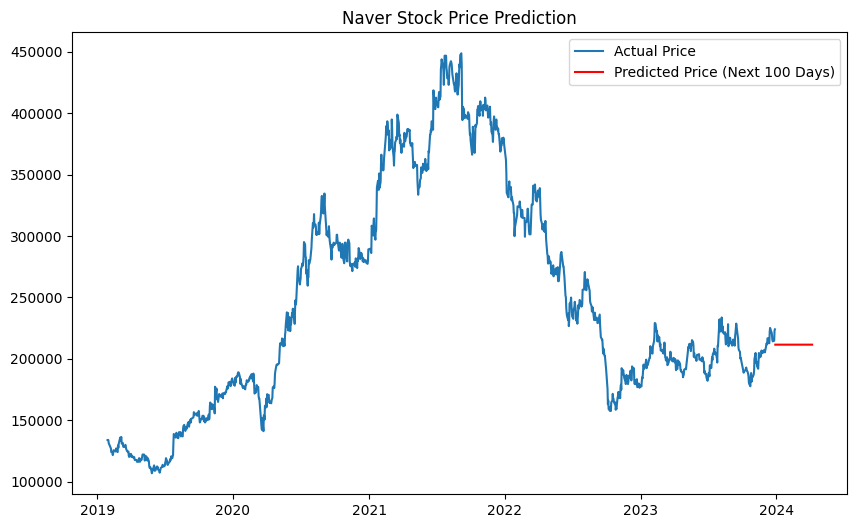

2023-12-29 00:00:00+00:00    211513.891719
2023-12-30 00:00:00+00:00    211522.672344
2023-12-31 00:00:00+00:00    211522.672344
2024-01-01 00:00:00+00:00    211522.672344
2024-01-02 00:00:00+00:00    211522.672344
                                 ...      
2024-04-02 00:00:00+00:00    211522.672344
2024-04-03 00:00:00+00:00    211522.672344
2024-04-04 00:00:00+00:00    211522.672344
2024-04-05 00:00:00+00:00    211522.672344
2024-04-06 00:00:00+00:00    211522.672344
Freq: D, Length: 100, dtype: float64


In [112]:
#예측된 주가 시각화
plt.figure(figsize=(10,6))
plt.plot(data.index, data['Close'], label='Actual Price')
plt.plot(predicted_prices_series.index, predicted_prices_series, label='Predicted Price (Next 100 Days)', color='red')
plt.title('Naver Stock Price Prediction')
plt.legend()
plt.show()

#예측된 가격 출력
print(predicted_prices_series)